## Les importations 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv

import time
import mediapipe as mp

import keras
from keras import *

from sklearn.model_selection import train_test_split
import tensorflow
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

## Création du modèle

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GlobalAveragePooling1D
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GlobalAveragePooling1D
import tensorflow as tf

def build_model():
    model = Sequential([
      
        Input(shape=(sequence_length, 1662)), 
        
        # Couches LSTM avec Dropout
        LSTM(128, return_sequences=True, activation='tanh'),
        Dropout(0.5),
        
        LSTM(256, return_sequences=True, activation='tanh'),
        Dropout(0.5),
        
        LSTM(128, return_sequences=True, activation='tanh'),
        
        # Global Average Pooling pour résumer la séquence
        GlobalAveragePooling1D(),
        
        # Couches Denses avec Dropout
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(len(actions), activation='softmax') 
    ])

    # Compilation du modèle
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  metrics=['categorical_accuracy'])
    
    return model

## Entraînement du modèle

In [4]:
def train_model(model, params, X_train, y_train, X_test, y_test):
    optim = optimizer(params)
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    log_dir, tb_callback = monitor_training()
    historique = model.fit(X_train, y_train, epochs=num_epochs, callbacks=[tb_callback])
    
    # Sauvegarder le modèle
    model.save(model_pth)
    
    # Prédictions sur le test set
    y_pred = model.predict(X_test)
    
    # Conversion des prédictions et des labels à partir de one-hot
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    
    # Matrice de confusion
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    # Affichage
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion')
    plt.show()
    
    # Rapport détaillé
    print("\n Rapport de classification :\n")
    print(classification_report(y_true_labels, y_pred_labels, target_names=actions))

    return historique


## Evalution du modèle

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, X_test, y_test, actions):
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    # Rapport de classification
    print("Rapport de classification :\n")
    print(classification_report(y_true_labels, y_pred_labels, target_names=actions))

    # Matrice de confusion
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=actions, yticklabels=actions)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.title("Matrice de confusion")
    plt.show()


## Affichage des corubes loss et pertes

In [6]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Tracer la précision
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'], label='Précision (train)')
    plt.title('Précision pendant l\'entraînement')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    # Tracer la perte
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perte (train)')
    plt.title('Perte pendant l\'entraînement')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    plt.tight_layout()
    plt.show()



## Division des données en train et test

In [7]:
def split_data(sequences, labels):
    X = np.array(sequences)
    y = to_categorical(labels).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test


##  Optimiseur adam

In [8]:
def optimizer(params):
    return keras.optimizers.Adam(learning_rate=params)


In [9]:
def monitor_training():
    log_dir = os.path.join('models', 'logs')
    tb_callback = TensorBoard(log_dir=log_dir)
    return log_dir, tb_callback

In [10]:

def process_data():
    sequences, labels = [], []
    for action in actions:
        for sequence in range(no_sequences):
            window = []
            for num_frame in range(sequence_length):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(num_frame)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    return sequences, labels


In [15]:
DATA_PATH = "MP_Data" 
actions = sorted([d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))])
print(actions)
no_sequences = 30 
sequence_length = 30  

['a', 'add', 'address', 'afraid', 'alarm', 'also', 'eyes', 'hello', 'iloveyou', 'love', 'thanks']


In [16]:
# Création du mapping des labels
label_map = {label: num for num, label in enumerate(actions)}

# Chargement des données
sequences, labels = process_data()
test_size = 0.2
# Conversion des labels en one-hot encoding
X_train, X_test, y_train, y_test = split_data(sequences, labels)


In [17]:
# Appel de la fonction pour entraîner le modèle
num_epochs = 500
model_pth = r"final_model.keras"
model = build_model()

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - categorical_accuracy: 0.9389 - loss: 0.1923
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - categorical_accuracy: 0.9450 - loss: 0.2234
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - categorical_accuracy: 0.9620 - loss: 0.1095
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - categorical_accuracy: 0.9764 - loss: 0.0704
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - categorical_accuracy: 0.9883 - loss: 0.0505
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - categorical_accuracy: 0.9779 - loss: 0.0524
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - categorical_accuracy: 0.9868 - loss: 0.0474
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - categorical_accuracy: 0.9754 - loss: 0.0809
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - categorical_accuracy: 0.9843 - loss: 0.0549
Epoch 10/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - categorical_accuracy: 0.9814 - loss: 0.0653
Epoch 11/500
9/9 ━━━━━━━━━━━━

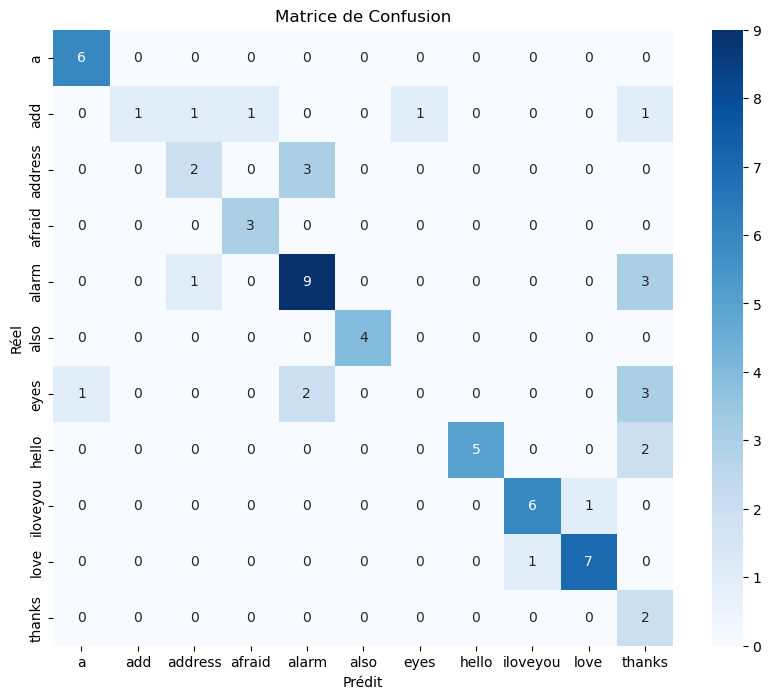


 Rapport de classification :

              precision    recall  f1-score   support

           a       0.86      1.00      0.92         6
         add       1.00      0.20      0.33         5
     address       0.50      0.40      0.44         5
      afraid       0.75      1.00      0.86         3
       alarm       0.64      0.69      0.67        13
        also       1.00      1.00      1.00         4
        eyes       0.00      0.00      0.00         6
       hello       1.00      0.71      0.83         7
    iloveyou       0.86      0.86      0.86         7
        love       0.88      0.88      0.88         8
      thanks       0.18      1.00      0.31         2

    accuracy                           0.68        66
   macro avg       0.70      0.70      0.65        66
weighted avg       0.72      0.68      0.67        66



In [29]:
historique = train_model(model, 0.001, X_train, y_train,X_test, y_test)

In [31]:
#plot_history(historique)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Rapport de classification :

              precision    recall  f1-score   support

           a       0.86      1.00      0.92         6
         add       0.33      0.40      0.36         5
     address       0.50      0.40      0.44         5
      afraid       0.75      1.00      0.86         3
       alarm       0.82      0.69      0.75        13
        also       1.00      1.00      1.00         4
        eyes       0.00      0.00      0.00         6
       hello       1.00      0.71      0.83         7
    iloveyou       0.86      0.86      0.86         7
        love       0.88      0.88      0.88         8
      thanks       0.22      1.00      0.36         2

    accuracy                           0.70        66
   macro avg       0.66      0.72      0.66        66
weighted avg       0.71      0.70      0.69        66



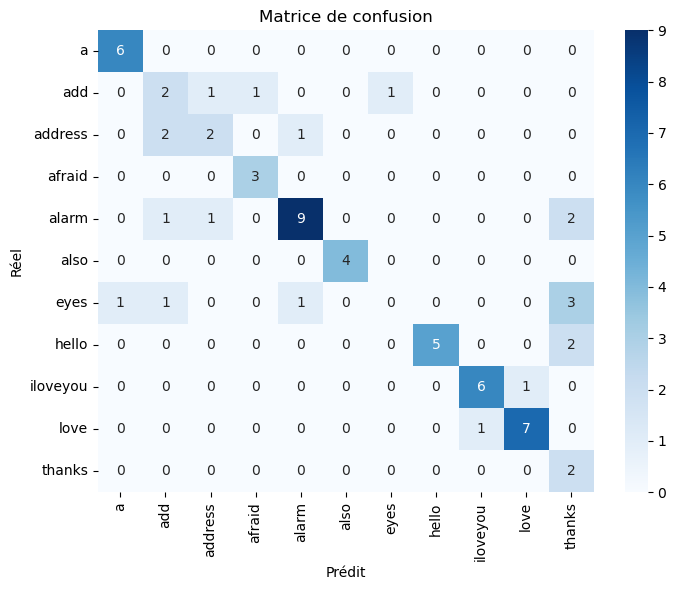

In [28]:
evaluate_model(model, X_test, y_test, actions)

In [32]:
import cv2
import numpy as np
from keras.models import load_model
import mediapipe as mp


# Chargement du modèle
model = load_model("final_model.keras")

# Initialisation Mediapipe
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Initialisation de la capture vidéo
cap = cv2.VideoCapture(0)

sequence = []
threshold = 0.8

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        # Détection
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        # Extraction des keypoints
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  

        # Prédiction si séquence suffisante
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            if res[np.argmax(res)] > threshold:
                predicted_action = actions[np.argmax(res)]
                cv2.putText(image, predicted_action, (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3, cv2.LINE_AA)

        # Affichage
        cv2.imshow('Detection LSF - Temps Réel', image)

        # Sortie avec touche 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


NameError: name 'mediapipe_detection' is not defined

In [36]:
cap.release()
cv2.destroyAllWindows()
